In [1]:
import pandas as pd
import talib
import glob
import errno
import numpy as np
import tushare as ts

'''
1，需要从 data/stockdata/ 文件夹里面提取出所有5分钟数据
2，合并成30分钟数据
3，生成 indicator 
4，
'''


'''
combine old 5 mins data.
'''
def combine_data(stockcode):
    read_filepath = 'data/stockdata/*/*' + stockcode + '.csv'
    files = glob.glob(read_filepath)

    file_list = []
    for file_name in files:
        file_list = file_list + [pd.read_csv(file_name,header=None)]

    result = pd.concat(file_list,ignore_index=True)
    result.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'amount']
    result['datetime'] = result[['date', 'time']].apply(lambda x: ' '.join(x), axis=1)
    
    data = result.sort_values(by='datetime')

    data = data[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')

    return data

'''
get day data and change name, save data to raw foloder.
'''
def combine_data_day(stockcode):
    read_filepath = 'data/day/*' + stockcode + '.csv'
    files = glob.glob(read_filepath)

    file_list = []
    for file_name in files:
        file_list = file_list + [pd.read_csv(file_name,header=None)]

    result = pd.concat(file_list,ignore_index=True)
    result.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'amount']

    data = result.sort_values(by='datetime')
    data = data[['datetime', 'open', 'high', 'low', 'close', 'volume']]
#     save to "finaldata/raw/D/stockcode.csv"
#     save_to_file(data, "D", stockcode, "raw")
#     print(data)
    return data


'''
get 5mins data from tushare, save data to data/newdata/5m/ folder
'''
def get_new_data_5m(stockcode, startdate, enddate):
    # api = ts.pro_api('fa7be38d5d25002c54139b5724a53463e250e8008ada18d75661222d')
    cons = ts.get_apis()
    data = ts.bar(stockcode, conn=cons, freq='5min', adj=None, start_date=startdate, end_date=enddate)
    df = pd.DataFrame(data=data, columns=['open', 'close', 'high', 'low', 'vol'])
    df.rename(index=str, columns={'vol':'volume'}, inplace=True)

    df.reset_index(level=0, inplace=True)
    df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]

    return df

'''
get day data from tushare
'''
def get_new_data_day(stockcode, startdate, enddate):
    # api = ts.pro_api('fa7be38d5d25002c54139b5724a53463e250e8008ada18d75661222d')
    cons = ts.get_apis()
    data = ts.bar(stockcode, conn=cons, adj='qfq', start_date=startdate, end_date=enddate)
    df = pd.DataFrame(data=data, columns=['open', 'close', 'high', 'low', 'vol'])
    df.rename(index=str, columns={'vol':'volume'}, inplace=True)    
    
    df.reset_index(level=0, inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
    df['volume'] = df['volume']*100
    df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    return df   

'''
combine tushare data to 30mins data, 
generate emro and save to "finaldata/current/30m/stockcode.CSV" file
'''
def combine_new_data_5m(stockcode, startdate):
    old_data = combine_data(stockcode)
    new_data = get_new_data_5m(stockcode=stockcode, startdate=startdate, enddate='')
    result = pd.concat([old_data, new_data],ignore_index=True)
    result = result.sort_values(by='datetime')
#     result.rename(columns={'datetime':'date'}, inplace=True)
#     print(result)
    return result


'''
combine tushare data to 30mins data, 
generate emro and save to "finaldata/current/30m/stockcode.CSV" file
'''
def combine_new_data_30m(stockcode, startdate):
    result = combine_new_data_5m(stockcode, startdate)
#     result.reset_index()
    groups = result.groupby(result.index // 6)
    df = groups.agg({
        'datetime': lambda x: x.iloc[-1], 
        'open': lambda x: x.iloc[0],
        'high': np.amax,
        'low': np.amin,
        'close': lambda x: x.iloc[-1],
        'volume': np.sum   
    })
    df = df.sort_values(by='datetime')
    return df


'''
combine tushare data to day data, 
generate emro and save to "finaldata/current/day/stockcode.CSV" file
'''
def combine_new_data_day(stockcode, startdate):
    old_data = combine_data_day(stockcode)
    new_data = get_new_data_day(stockcode=stockcode, startdate=startdate, enddate='')
    result = pd.concat([old_data, new_data],ignore_index=True)
    result = result.sort_values(by='datetime')
#     result.rename(columns={'datetime':'date'}, inplace=True)
    return result

'''
general file save function.
'''
def save_to_file(data, timeframe, stockcode):
    filepath = "data/current" + "/" + timeframe + "/" + stockcode + ".CSV"
    print("saved file path is ", filepath)
    data.to_csv(filepath,index=False)
    

def create_indicator(df):

    # remove invalid volume data

    # df = df[df['Volume']!=0]

    # parms = talib.ADXR(df['High'], df['Low'], df['Close'], timeperiod=14)
    # parms = talib.APO(df['Close'], fastperiod=12, slowperiod=26, matype=0)
    # bop = talib.BOP(df['Open'],df['High'], df['Low'], df['Close'])

    ema25 = talib.EMA(df['close'], timeperiod=25)
    ema10 = talib.EMA(df['close'], timeperiod=10)
    ema5 = talib.EMA(df['close'], timeperiod=5)

    mavol5 = talib.EMA(df['volume'], timeperiod=5)
    mavol20 = talib.EMA(df['volume'], timeperiod=20)
    mavol100 = talib.EMA(df['volume'], timeperiod=100)

    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9) 

    slowk, slowd = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

    df['ema25'] = ema25
    df['ema10'] = ema10
    df['ema5'] = ema5

    df['dif'] = macd
    df['dea'] = macdsignal
    df['macd'] = macdhist
    df['mavol5'] = mavol5
    df['mavol20'] = mavol20
    df['mavol100'] = mavol100

    df['mavol5'] = df['mavol5'].fillna(0)
    df['mavol20'] = df['mavol20'].fillna(0)
    df['mavol100'] = df['mavol100'].fillna(0)

    df['ema25'] = df['ema25'].fillna(0)
    df['ema10'] = df['ema10'].fillna(0)
    df['ema5'] = df['ema5'].fillna(0)

    df['dif'] = df['dif'].fillna(0)
    df['dea'] = df['dea'].fillna(0)
    df['macd'] = df['macd'].fillna(0)

    #either fillna or cut first 33 lines.
    df = df[33:]
#     print(df)
#     save_to_file(df, timeframe, stockcode, datatype=datatype)
    return df



    
    


 



In [2]:
# combine_data("002446")
# get_new_data_5m("002446", "2019-04-01", "")

# combine_new_data_5m("002446", "2019-04-01")
# save data_5m (ohlc) to file 


# combine_data_day("002446")
# get_new_data_day("002446", "2019-04-02", "")
code = "002249"
data_day = combine_new_data_day(code, "2019-04-01")
save_to_file(data_day, "day", code)

data_30m = combine_new_data_30m(code, "2019-04-01")
save_to_file(data_30m, "30m", code)

data_30m = combine_new_data_5m(code, "2019-04-01")
save_to_file(data_30m, "5m", code)


# save data to 30
# create_indicator(data_day)
# combine_new_data_30m("002446", "2019-04-01")

NameError: name 'combine_new_data_day' is not defined

## notify order sample

Starting Portfolio Value: 30000.00
2018-06-22, Close, 6.42
2018-06-25, Close, 6.43
2018-06-26, Close, 6.57
2018-06-27, Close, 6.59
2018-06-28, Close, 6.60
2018-06-29, Close, 6.86
2018-06-29, BUY CREATE, 6.86
2018-07-02, ORDER SUBMITTED
2018-07-02, ORDER SUBMITTED
2018-07-02, BUY EXECUTED, Price: 6.89, Cost: 3445.00, Comm 0.00
2018-07-02, Close, 6.74
2018-07-02, SELL CREATE, 6.74
2018-07-03, ORDER SUBMITTED
2018-07-03, ORDER SUBMITTED
2018-07-03, SELL EXECUTED, Price: 6.80, Cost: 3445.00, Comm 0.00
2018-07-03, OPERATION PROFIT, GROSS -45.00, NET -45.00
2018-07-03, Close, 6.97
2018-07-03, BUY CREATE, 6.97
2018-07-04, ORDER SUBMITTED
2018-07-04, ORDER SUBMITTED
2018-07-04, BUY EXECUTED, Price: 6.91, Cost: 3455.00, Comm 0.00
2018-07-04, Close, 6.86
2018-07-05, Close, 6.50
2018-07-05, SELL CREATE, 6.50
2018-07-06, ORDER SUBMITTED
2018-07-06, ORDER SUBMITTED
2018-07-06, SELL EXECUTED, Price: 6.55, Cost: 3455.00, Comm 0.00
2018-07-06, OPERATION PROFIT, GROSS -180.00, NET -180.00
2018-07-06, C

<IPython.core.display.Javascript object>


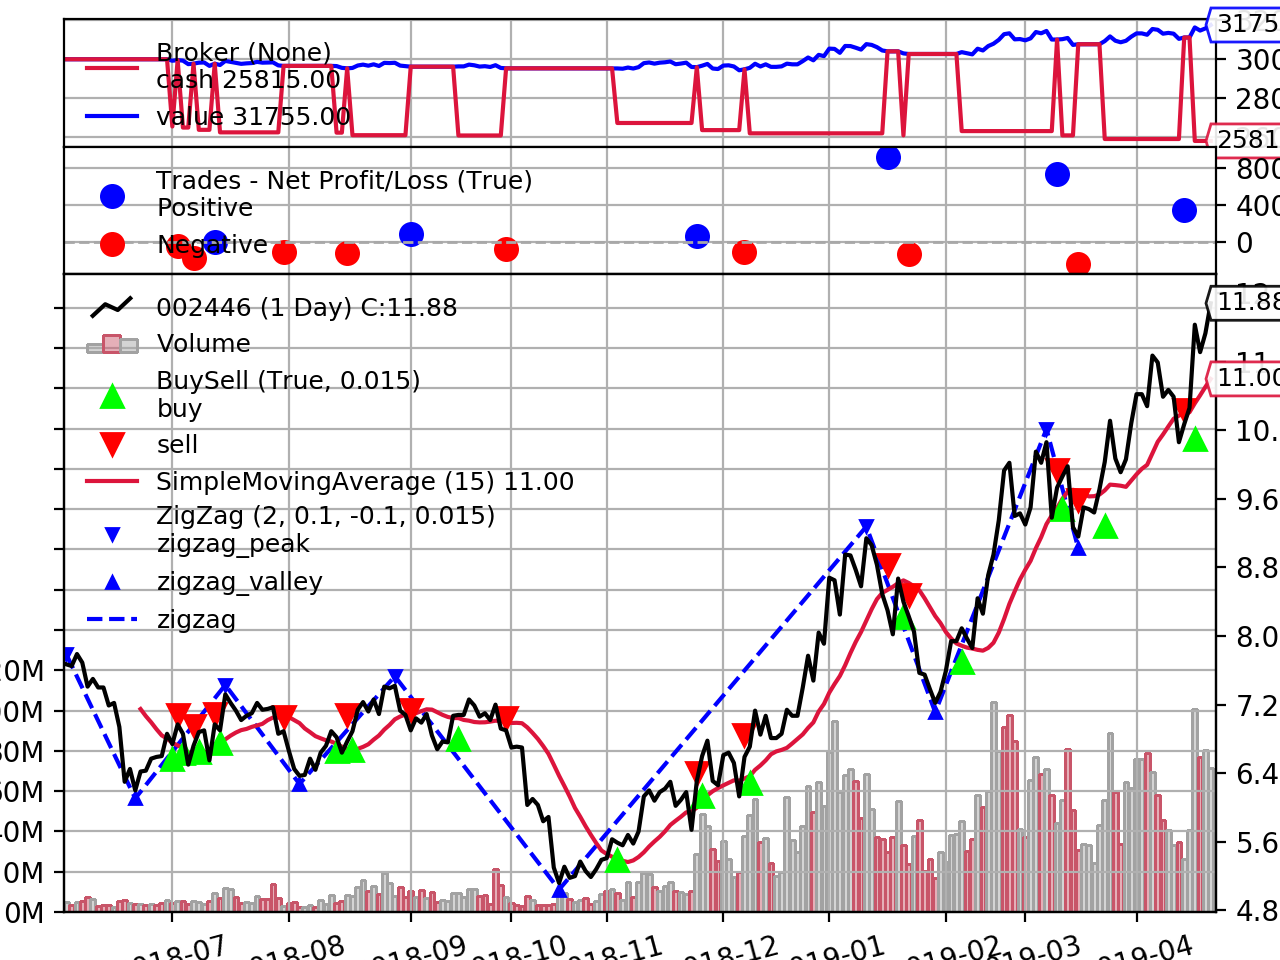

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.feeds as btfeeds
import stragety.indicators.zigzag as zz
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)
        zz.ZigZag()
        # Indicators for the plotting show
#         bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
#         bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
#                                             subplot=True)
#         bt.indicators.StochasticSlow(self.datas[0])
#         bt.indicators.MACDHisto(self.datas[0])
#         rsi = bt.indicators.RSI(self.datas[0])
#         bt.indicators.SmoothedMovingAverage(rsi, period=10)
#         bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log(
                    'ORDER SUBMITTED'
                    )
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=500)

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=500)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    data = btfeeds.GenericCSVData(
        dataname="data/current/day/002446.CSV",

        fromdate=datetime.datetime(2018, 6, 1),
        todate=datetime.datetime(2019, 4, 20),

        nullvalue=0.0,

        dtformat=('%Y-%m-%d'),

        datetime=0,
        open=1,
        high=2,
        low=3,
        close=4,
        volume=5,
        openinterest=-1
    )


    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(30000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot()

## Multiple Timeframes

--------------------------------------------------
nextstart called with len 58
--------------------------------------------------


<IPython.core.display.Javascript object>


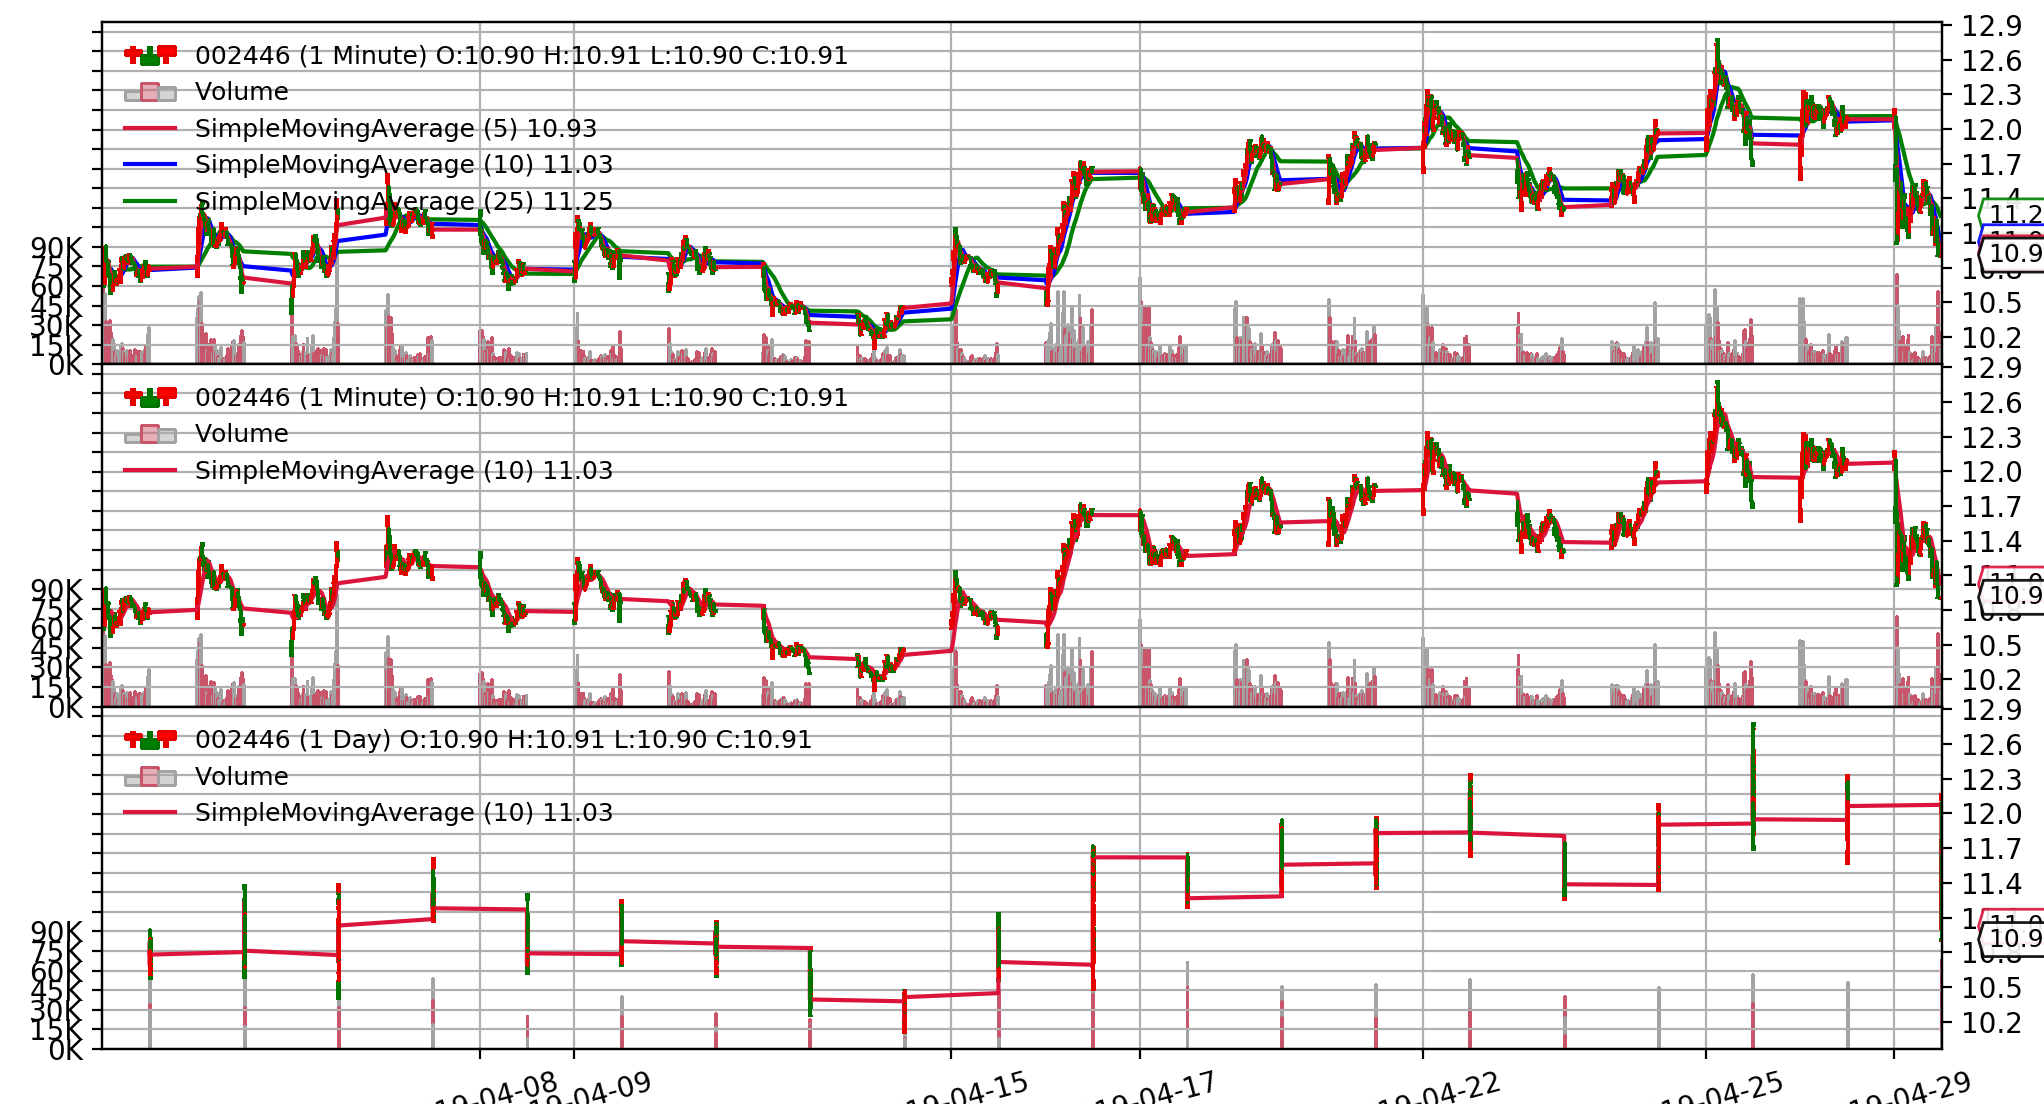

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import argparse

import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind


class SMAStrategy(bt.Strategy):
    params = (
        ('period', 10),
    )

    def __init__(self):
        self.sma_5m_5 = sma_5m_5 = bt.indicators.SimpleMovingAverage(self.data0, period=5)
        self.sma_5m_10 = sma_5m_10 = bt.indicators.SimpleMovingAverage(self.data0, period=10)
        self.sma_5m_25 = sma_5m_25 = bt.indicators.SimpleMovingAverage(self.data0, period=25)
        # sma_5m_tf()
        
        self.sma_30m_tf = sma_30m_tf = bt.indicators.SimpleMovingAverage(self.data1, period=self.p.period)
        # sma_30m_tf()

        self.sma_day_tf = sma_day_tf = bt.indicators.SimpleMovingAverage(self.data2, period=self.p.period)
        # sma_day_tf()
   
    def nextstart(self):
        print('--------------------------------------------------')
        print('nextstart called with len', len(self))
        print('--------------------------------------------------')

        super(SMAStrategy, self).nextstart()


def runstrat():
    # Create a cerebro entity
    cerebro = bt.Cerebro(stdstats=False)
    
    cerebro.addstrategy(
        SMAStrategy,
        # args for the strategy
        period=10,
    )

    datapath0 = '/Users/kevin_gwdong/djangoproject/tensorflow/quantity/data/current/5m/002446.CSV'
    datapath1 = '/Users/kevin_gwdong/djangoproject/tensorflow/quantity/data/current/30m/002446.CSV'
    datapath2 = '/Users/kevin_gwdong/djangoproject/tensorflow/quantity/data/current/day/002446.CSV'
    
    data0 = btfeeds.GenericCSVData(
        dataname=datapath0, 
        dtformat=('%Y-%m-%d %H:%M:%S'),
        openinterest=-1,
        fromdate=datetime.datetime(2019, 4, 1),
        todate=datetime.datetime(2019, 4, 30),
        timeframe=bt.TimeFrame.Minutes,
        compression = 1,
    )
    cerebro.adddata(data0)
    
    data1 = btfeeds.GenericCSVData(
        dataname=datapath1, 
        dtformat=('%Y-%m-%d %H:%M:%S'),
        openinterest=-1,
        fromdate=datetime.datetime(2019, 4, 1),
        todate=datetime.datetime(2019, 4, 30),
        timeframe=bt.TimeFrame.Minutes,
        compression = 1,
    )
    cerebro.adddata(data1)
    
    data2 = btfeeds.GenericCSVData(
        dataname=datapath2, 
        dtformat=('%Y-%m-%d'),
        openinterest=-1,
        fromdate=datetime.datetime(2019, 4, 1),
        todate=datetime.datetime(2019, 4, 30),
        timeframe=bt.TimeFrame.Days,
        compression = 1,
    )
    cerebro.adddata(data2)
    
    # data1 = btfeeds.GenericCSVData(
    #     dataname=datapath1, 
    #     dtformat=('%Y-%m-%d %H:%M:%S'),
    #     openinterest=-1,
    #     fromdate=datetime.datetime(2019, 3, 1),
    #     todate=datetime.datetime(2019, 4, 30),
    #     timeframe=bt.TimeFrame.Minutes,
    #     compression = 1,
    # )
    # cerebro.adddata(data1)

#     cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=6)
#     cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=48)
    cerebro.run()

    # Plot the result
    cerebro.plot(style='candle', barup = 'red', bardown = 'green')


if __name__ == '__main__':
    runstrat()

Starting Portfolio Value: 10000.00
Final Portfolio Value: 9352.00


<IPython.core.display.Javascript object>


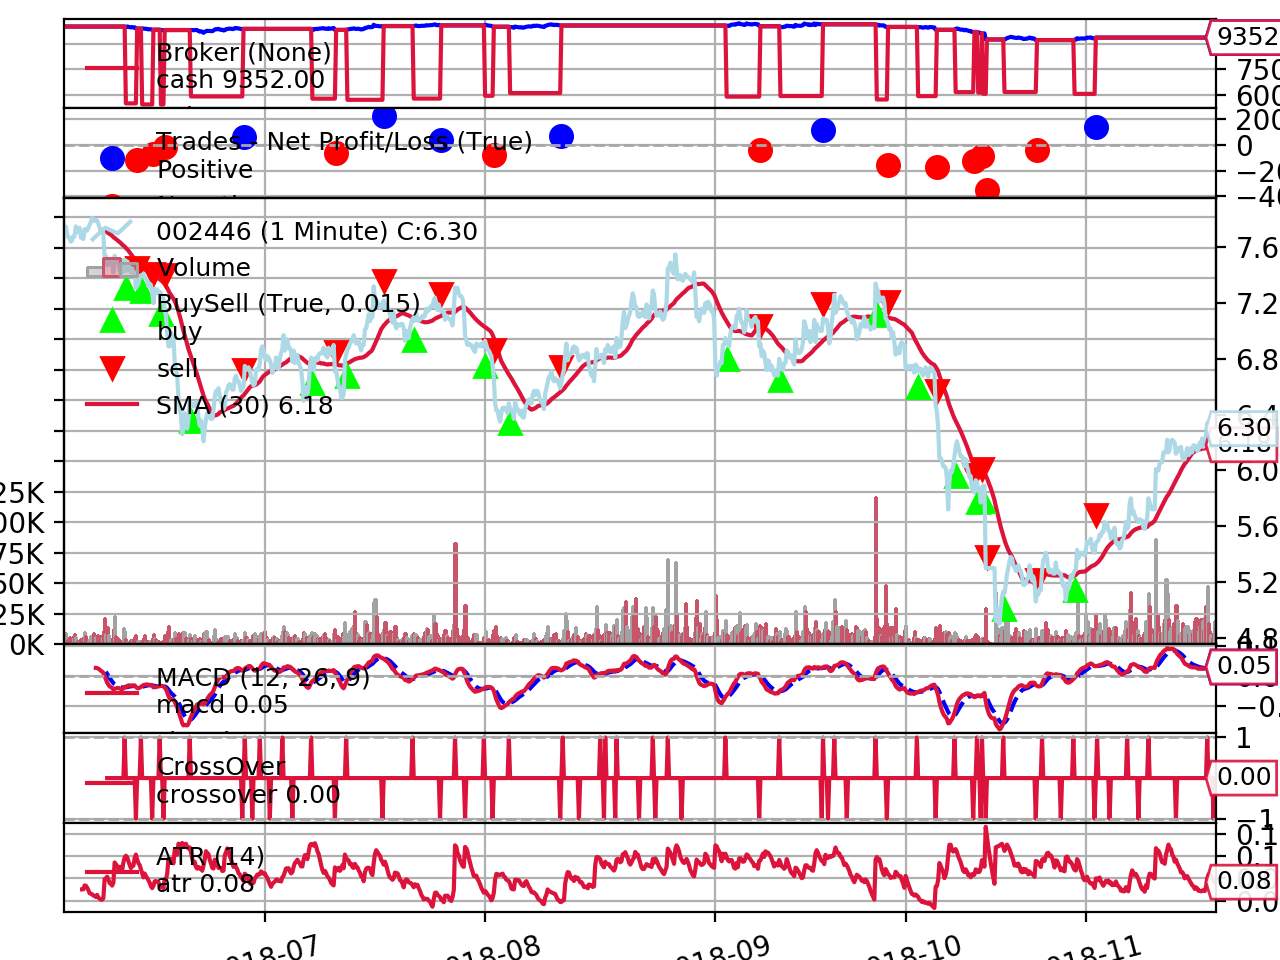

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8; py-indent-offset:4 -*-

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import argparse
import datetime
import random

import backtrader as bt
import backtrader.feeds as btfeeds

BTVERSION = tuple(int(x) for x in bt.__version__.split('.'))


class FixedPerc(bt.Sizer):
    '''This sizer simply returns a fixed size for any operation

    Params:
      - ``perc`` (default: ``0.20``) Perc of cash to allocate for operation
    '''

    params = (
        ('perc', 0.30),  # perc of cash to use for operation
    )

    def _getsizing(self, comminfo, cash, data, isbuy):
        cashtouse = self.p.perc * cash
        if BTVERSION > (1, 7, 1, 93):
            size = comminfo.getsize(data.close[0], cashtouse)
        else:
            size = cashtouse // data.close[0]
        return size


class TheStrategy(bt.Strategy):
    '''
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)

     - Set a stop price x times the ATR value away from the close

     - If in the market:

       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 3.0),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )

    def notify_order(self, order):
        if order.status == order.Completed:
            pass

        if not order.alive():
            self.order = None  # indicate no order is pending

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0:
#             if self.mcross[0] > 0.0:
                self.order = self.buy()
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] - pdist

        else:  # in the market
            pclose = self.data.close[0]
            pstop = self.pstop

#             if pclose < pstop or self.mcross[0] < 0.0:
            if self.mcross[0] < 0.0:
                self.sell()  # stop met - get out
            else:
                pdist = self.atr[0] * self.p.atrdist
                # Update only if greater than
                self.pstop = max(pstop, pclose - pdist)




def runstrat(args=None):

    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TheStrategy)

    data = btfeeds.GenericCSVData(
        dataname="/Users/kevin_gwdong/djangoproject/tensorflow/quantity/data/current/30m/002446.CSV",

        fromdate=datetime.datetime(2018, 6, 1),
        todate=datetime.datetime(2018, 11, 20),

        nullvalue=0.0,

        dtformat=('%Y-%m-%d %H:%M:%S'),

        datetime=0,
        open=1,
        high=2,
        low=3,
        close=4,
        volume=5,
        openinterest=-1,
        timeframe=bt.TimeFrame.Minutes,
    )


    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)
    
    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=600)
#     cerebro.addsizer(FixedPerc, perc=0.6)
    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(style='line', loc='lightblue')


if __name__ == '__main__':
    runstrat()
